# LeNet-5 CIFAR10 Classifier

LILI TANG

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to the CIFAR10 object classification dataset. The basic architecture is shown in the figure in the lecture slides.



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.

**Please note that the original architecture was applied to MNIST-like grayscale images (1 color channel). CIFAR-10 has 3 color-channels. I found that using the regular architecture results in very poor performance on CIFAR10 (approx. 65% ACC). Hence the goal of this lab is to try various techniques such as changing the number of kernels by a factor to improve the performance or changing other parameters of the network. You should at the end provide justification for your changes. The goal is not necessarily to improve the performance to 90% but understand the impact of various hyperparameters in network design.

### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

In [14]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings(adjust)

In [15]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005 # adjust value from 0.001 to 0.0005
BATCH_SIZE = 64 # adjust value from 128 to 64
NUM_EPOCHS = 30 # adjust value 10 to 20

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

### Calculate mean and standard deviation(add)

In [16]:
train_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=train_transform,
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)



def get_mean_and_std(loader):
   mean=0
   std=0
   total_images_count=0
   for images,_ in loader:
       image_count_in_a_batch=images.size(0)
       images=images.view(image_count_in_a_batch, images.size(1),-1)
       mean+=images.mean(2).sum(0)
       std+=images.std(2).sum(0)
       total_images_count+=image_count_in_a_batch
   mean/=total_images_count
   std/=total_images_count
   return mean, std

get_mean_and_std(train_loader)

Files already downloaded and verified


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

### CIFAR-10 Dataset

In [17]:
##########################
### CIFAR-10 Dataset
##########################

train_mean = (0.4914, 0.4822, 0.4465) # change values
train_std = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.RandomHorizontalFlip(),## data argumentation
                                      transforms.RandomCrop(32, padding=4),## data argumentation
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_mean, train_std)])

test_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_mean, train_std)])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=train_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=test_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [18]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
Epoch: 2 | Batch index: 0 | Batch size: 64


In [19]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.BatchNorm2d(6*in_channels),#normalization
            nn.ReLU(), # change activation function from tanh
            nn.MaxPool2d(kernel_size=2,stride = 2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.BatchNorm2d(16*in_channels),
            nn.ReLU(),# change activation function from tanh
            nn.MaxPool2d(kernel_size=2,stride = 2)
            
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels), # 400 *120
            nn.ReLU(),# change activation function from tanh
            nn.Dropout(0.25),# regularization technique by dropout
            nn.Linear(120*in_channels, 84*in_channels), 
            nn.ReLU(),# change activation function from tanh
            nn.Dropout(0.25),# regularization technique by dropout
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [20]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [21]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/030 | Batch 0000/0782 | Cost: 2.3051
Epoch: 001/030 | Batch 0050/0782 | Cost: 1.8285
Epoch: 001/030 | Batch 0100/0782 | Cost: 1.9394
Epoch: 001/030 | Batch 0150/0782 | Cost: 1.7489
Epoch: 001/030 | Batch 0200/0782 | Cost: 1.6630
Epoch: 001/030 | Batch 0250/0782 | Cost: 1.4740
Epoch: 001/030 | Batch 0300/0782 | Cost: 1.7880
Epoch: 001/030 | Batch 0350/0782 | Cost: 1.5535
Epoch: 001/030 | Batch 0400/0782 | Cost: 1.6259
Epoch: 001/030 | Batch 0450/0782 | Cost: 1.4399
Epoch: 001/030 | Batch 0500/0782 | Cost: 1.6029
Epoch: 001/030 | Batch 0550/0782 | Cost: 1.3833
Epoch: 001/030 | Batch 0600/0782 | Cost: 1.2855
Epoch: 001/030 | Batch 0650/0782 | Cost: 1.3228
Epoch: 001/030 | Batch 0700/0782 | Cost: 1.3850
Epoch: 001/030 | Batch 0750/0782 | Cost: 1.5005
Epoch: 001/030 | Train: 51.282%
Time elapsed: 0.82 min
Epoch: 002/030 | Batch 0000/0782 | Cost: 1.4390
Epoch: 002/030 | Batch 0050/0782 | Cost: 1.5219
Epoch: 002/030 | Batch 0100/0782 | Cost: 1.3649
Epoch: 002/030 | Batch 0150/0782 

## Evaluation

In [22]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 78.72%


In [23]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Train accuracy: %.2f%%' % (compute_accuracy(model, train_loader, device=DEVICE)))

Train accuracy: 78.54%


In [24]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.

        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=train_mean, std=train_std)

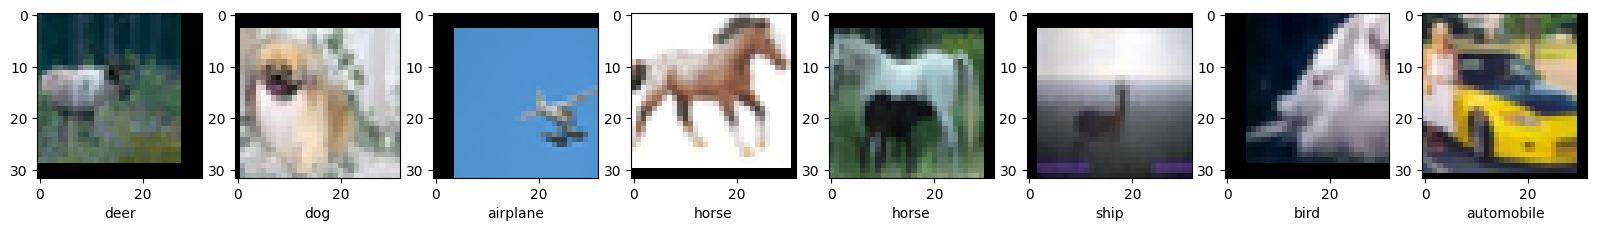

In [25]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'airplane',
     1: 'automobile',
     2: 'bird',
     3: 'cat',
     4: 'deer',
     5: 'dog',
     6: 'frog',
     7: 'horse',
     8: 'ship',
     9: 'truck'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

### Overall, I use several methods to increse the test accuracy rate from 67% to 79%

#### 1.  Data argumentation method: accuracy rate increased from 67% to 70%
Finding a better mean and standard deviation of image dataset rather than just using (0.5, 0.5, 0.5)value for transfroms.normalise. Also, adding random cropping and fliping the input image horizontally with a probability of 0.5.

#### 2. Change activation function and use regularization technique(dropout), accuracy rate increased from 70% to 73%
Changing activation function from tanh to relu and also using regularization technique by dropout. ReLU has a property known as sparsity, which means that many of the activations in the network are zero. This can help to prevent overfitting and improve the generalization performance of the network. Dropout is a regularization technique commonly used in deep neural networks to prevent overfitting.

#### 3. Adjust Hyperparameters of learning rate, batch size and number of epochs, accuracy rate increased from 73% to 79%      
Reducing learning rate from 0.001 to 0.0005: a smaller learning rate can help the network converge to a better solution by allowing it to more carefully explore the space of possible weight configurations.     
Reducing batch size from 128 to 32: a smaller batch size can help prevent overfitting by reducing the amount of noise in the weight updates
Increasing number of epochs from 10 to 30: a small number of epochs may result in underfitting, where the network does not learn the patterns in the data well enough, therefore I increase the numeber of epochs.
